In [17]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales
import seaborn as sns

In [64]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica_mod = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    return tica_mod.get_output()


def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int, n_jobs: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=n_jobs)
    dtrajs = kmeans.dtrajs
    return dtrajs

In [65]:
hp_ix = 0
protein = '1fme'
seed = 49587
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
n_bootstraps = 1
nits=25

hps = pd.read_hdf('../data/msms/hpsample.h5')
top_path = f'/home/rob/Data/DESRES/DESRES-Trajectory_{protein.upper()}-0-protein/{protein.upper()}-0-protein/protein.pdb'
traj_paths = list(Path('/home/rob/Data/DESRES/').rglob(f'*{protein.upper()}*/**/*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
assert traj_paths


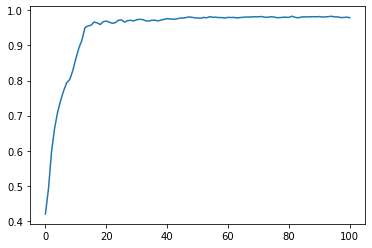

In [73]:
ftrajs_all = featurizer(hps.iloc[hp_ix, :].to_dict(), traj_paths, top_path)

ttrajs = tica(hps.iloc[hp_ix, :].to_dict(), ftrajs_all)

dtrajs1 = kmeans(hps.iloc[hp_ix, :].to_dict(), ttrajs, seed=49587, n_jobs=1)

dtrajs12 = kmeans(hps.iloc[hp_ix, :].to_dict(), ttrajs, seed=49587, n_jobs=12)

its1 = pm.msm.timescales_msm(dtrajs1, nits=25, lags=list(range(1,102,1)))
its12 = pm.msm.timescales_msm(dtrajs12, nits=25, lags=list(range(1,102,1)))

plt.plot(its1.timescales[:, 0]/its12.timescales[:, 0])